In [75]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm


In [76]:

if torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

mps


In [152]:
path = "images/pexels-samandgos-709552.jpg"
im = Image.open(path)
im_tensor_cpu = to_tensor(im).to(device="cpu")
im_tensor_mps =to_tensor(im).to(device="mps") 
print(f"inital tensor size : {im_tensor_cpu.shape}")


max_dim = 250
_, H, W = im_tensor_mps.shape
scale_factor = max_dim / max(H, W)

new_H = int(H * scale_factor)
new_W = int(W * scale_factor)
im_resized = resize(im_tensor_mps.unsqueeze(0), size=[new_H, new_W], antialias=True).squeeze(0)

print(f"rescaled tensor size : {im_resized.shape}")

inital tensor size : torch.Size([3, 2336, 3504])
rescaled tensor size : torch.Size([3, 166, 250])


In [154]:
min_dim = 25            # dimension mini au coarse scale
N = 0
current_H, current_W = new_H, new_W
r = 4 / 3               # scaling factor (environ 1.333)

# Calculer N tel que le coarse scale soit >= min_dim
while current_H >= min_dim and current_W >= min_dim:
    N += 1
    current_H = int(current_H / r)
    current_W = int(current_W / r)
N

7

In [155]:
scales = [im_resized.unsqueeze(0)]    # niveau 0 = fine

for i in range(1, N):
    prev = scales[-1]
    _, _, h, w = prev.shape
    new_h = max(int(h / r), 1)
    new_w = max(int(w / r), 1)
    down = resize(prev, size=[new_h, new_w], antialias=True)
    scales.append(down)


Number of scales N = 7
Scaling factor r = 1.333
Scale 0 : torch.Size([1, 3, 166, 250])


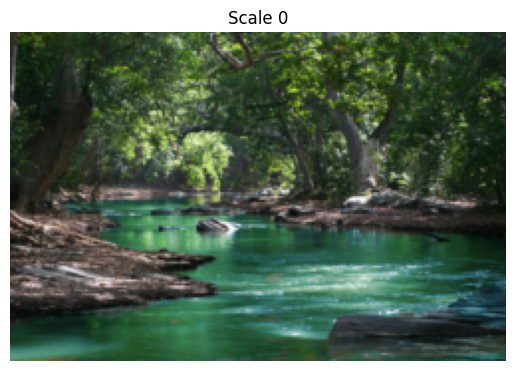

Scale 1 : torch.Size([1, 3, 124, 187])


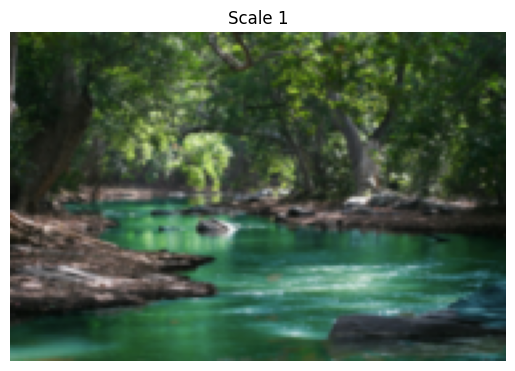

Scale 2 : torch.Size([1, 3, 93, 140])


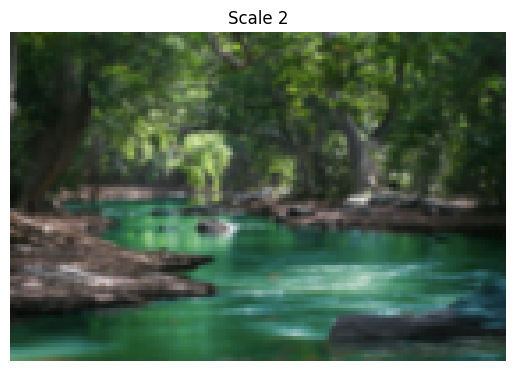

Scale 3 : torch.Size([1, 3, 69, 105])


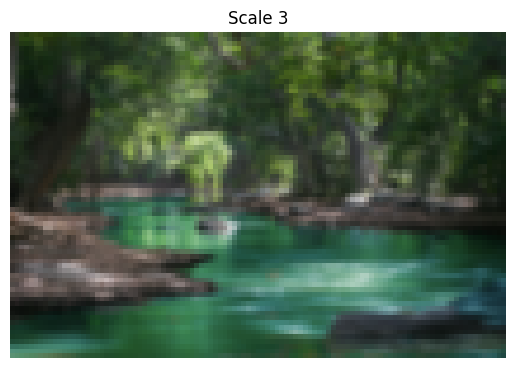

Scale 4 : torch.Size([1, 3, 51, 78])


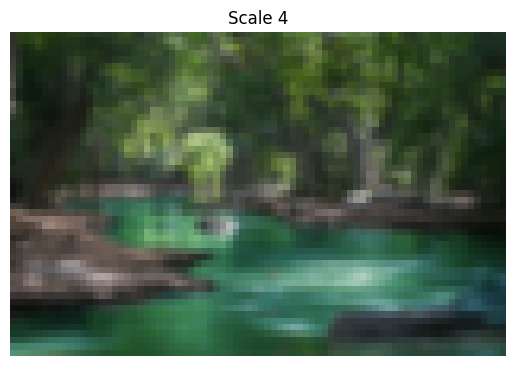

Scale 5 : torch.Size([1, 3, 38, 58])


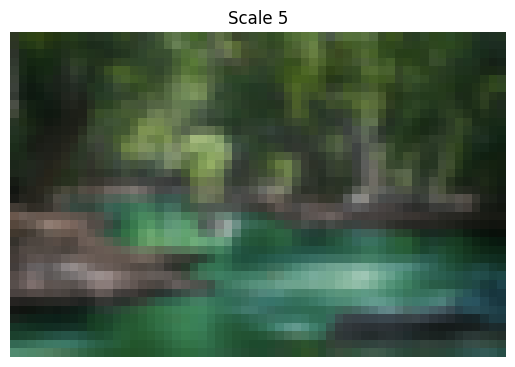

Scale 6 : torch.Size([1, 3, 28, 43])


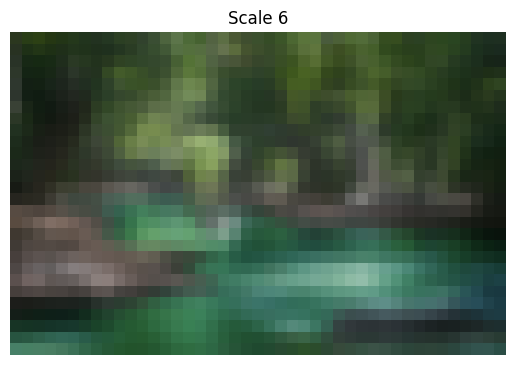

In [156]:
print(f"Number of scales N = {N}")
print(f"Scaling factor r = {r:.3f}")
for i, im_scale in enumerate(scales):
    print(f"Scale {i} : {im_scale.shape}")
    plt.imshow(to_pil_image(im_scale.squeeze().cpu()))
    plt.axis('off')
    plt.title(f"Scale {i}")
    plt.show()


In [157]:
class Generator(nn.Module):
    
    def __init__(self,n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            # Last conv layer outputs 3 channels (RGB), no batchnorm or activation
            nn.Conv2d(self.n_hidden, 3, 3, padding=1)
        )
        
    def forward(self,input):
        return self.main(input)

In [158]:
class Discriminator(nn.Module):
    def __init__(self,n_hidden):
        
        super().__init__()
        self.n_hidden = n_hidden
        self.main = nn.Sequential(
            nn.Conv2d(3, self.n_hidden, kernel_size=3, padding=1),  
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, self.n_hidden, 3, padding=1),
            nn.BatchNorm2d(self.n_hidden),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.n_hidden, 1, 3, padding=1)  
        )
    
    def forward(self,input):
        return self.main(input)

In [80]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
Total params: 29,763
Trainable params: 

In [81]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [159]:
hidden_lowest_dim = 32
Genarators = []
Discriminators = []

for i in range(N):
    r = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(r//4)).to(device))
    Discriminators.append(Discriminator(hidden_lowest_dim * 2**(r//4)).to(device))
    
Genarators.reverse()
Discriminators.reverse()

for gen in Genarators : 
     print(gen.n_hidden)
for dis in Discriminators:
     print(dis.n_hidden)


32
32
32
64
64
64
64
32
32
32
64
64
64
64


+ Boucle d'entrainement 

In [160]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


for G in Genarators:
    G.apply(weights_init)
for D in Discriminators:
    D.apply(weights_init)

it scale 6:   0%|          | 0/2000 [00:00<?, ?it/s]

sigma : 0.03418407961726189


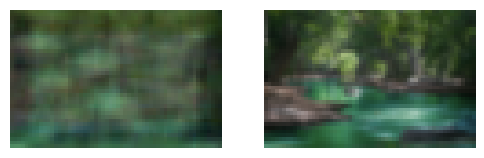

sigma : 0.08960927277803421


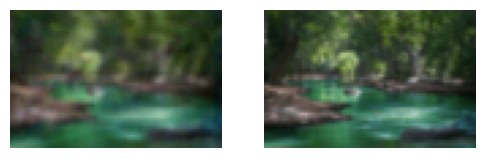

sigma : 0.08466032892465591


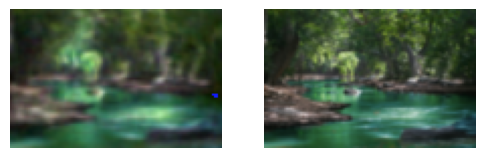

sigma : 0.08905036002397537


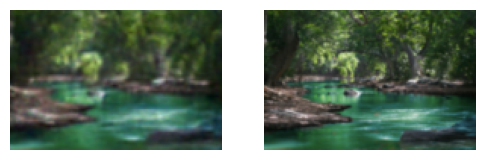

sigma : 0.09311240911483765


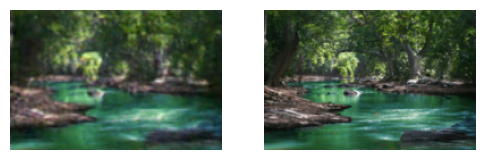

sigma : 0.10331356525421143


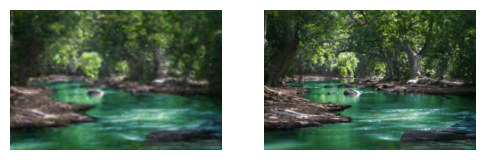

In [ ]:
torch.random.manual_seed(0)

# ───────────── 0. hypers
lambda_gp      = 10
lr             = 5e-4
betas          = (0.0, 0.9)
n_Discriminator       = 5
iter_per_scale = 2_000
alpha_rec      = 100
debug          = True

# ───────────── 1. optimiseurs
optimizer_G, optimizer_D = [], []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))
    optimizer_D.append(optim.Adam(Discriminators[i].parameters(), lr=lr, betas=betas))

# ───────────── 2. buffers pyramide
b, c, h, w = scales[-1].shape                    
null_image = torch.zeros((b,c,h,w), device=device)
gen_image  = [null_image]

z_star = torch.randn_like(scales[-1], device=device)              # bruit fixe
x_rec  = [None]*N                                                 
sigma_n = [1.0]*N                                                 

@torch.no_grad()                                                  
def forward_reconstruction(start_idx):
    """calcule x_rec[k] pour k >= start_idx (coarse = N-1)"""
    if start_idx > N-1: return
    for k in range(N-1, start_idx-1, -1):
        if k == N-1:
            x_rec[k] = Genarators[k](z_star)
        else:
            up = F.interpolate(x_rec[k+1], size=scales[k].shape[2:], mode='bilinear', align_corners=False)
            x_rec[k] = Genarators[k](up) + up

# ───────────── 3. boucle coarse → fine
for n in range(N):                                 
    current_res = N - n - 1
    current_gen  = Genarators[current_res].train()
    current_disc = Discriminators[current_res].train()
    current_target = scales[current_res].to(device)
    opt_G = optimizer_G[current_res]
    opt_D = optimizer_D[current_res]

    # ---------- reconstruction et sigma ----------
    forward_reconstruction(current_res + 1)
                       
    if current_res < N-1:                                      
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=current_target.shape[2:], mode='bilinear', align_corners=False)
        sigma_n[current_res] = torch.sqrt(F.mse_loss(up_rec, current_target)).item()
        print(f"sigma : {sigma_n[current_res]}")
    else:
        sigma_n[current_res] = 1.0

    # ---------- prev_img (upsample)
    prev_img = gen_image[-1]
    if prev_img.shape[2:] != current_target.shape[2:]:
        prev_img = F.interpolate(prev_img, size=current_target.shape[2:], mode='bilinear', align_corners=False)
        

    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):
        for _ in range(n_Discriminator):
            opt_D.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]        # <# ADDED >
            gen_out = current_gen(z + prev_img) + prev_img

            real_pred = current_disc(current_target).mean()
            fake_pred = current_disc(gen_out.detach()).mean()
            loss_D = fake_pred - real_pred

            alpha = torch.rand(b,1,1,1,device=device)
            interp = (alpha*current_target + (1-alpha)*gen_out.detach()).requires_grad_(True)
            grad_out = current_disc(interp).mean()
            grad = torch.autograd.grad(grad_out, interp, torch.ones_like(grad_out),
                                       create_graph=True, retain_graph=True, only_inputs=True)[0]
            gp = lambda_gp * ((grad.view(b,-1).norm(2,dim=1)-1)**2).mean()
            (loss_D + gp).backward()
            opt_D.step()

        opt_G.zero_grad()
        if current_res<N-1 :
            z = torch.randn_like(prev_img) * sigma_n[current_res]
        else : 
            z = torch.randn_like(prev_img)
               
        gen_out = current_gen(z + prev_img) + prev_img
        adv_G   = -current_disc(gen_out).mean()

        if current_res == N-1:
            Lrec = F.mse_loss(current_gen(z_star), current_target)
        else:
            Lrec = F.mse_loss(current_gen(up_rec) + up_rec, current_target)

        loss_G = adv_G + alpha_rec * Lrec
        loss_G.backward()
        opt_G.step()

    #  figer G_n et stocker image
    with torch.no_grad():
        gen_image.append(gen_out.detach())
        for p in current_gen.parameters():                        
            p.requires_grad_(False)
        current_gen.eval()     
    if debug:
        plt.figure(figsize=(6,3)); plt.subplot(1,2,1); plt.imshow(to_pil_image(gen_image[-1].squeeze())); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(to_pil_image(current_target.squeeze())); plt.axis('off'); plt.show()                                  


In [235]:
@torch.no_grad()
def generate_multiscale(Generators, N, scales, sigma_n, z_star, device='mps', start_scale=0):
    height, width = scales[-1].shape[2], scales[-1].shape[3]
    null_image = torch.zeros((1, 3, height, width), device=device)
    gen_image = [null_image]

    for i in range(N):
        current_res = N - i - 1
        current_gen = Generators[current_res].eval()
        prev_img = gen_image[-1]

        if prev_img.shape[2:] != scales[current_res].shape[2:]:
            prev_img = torch.nn.functional.interpolate(prev_img, size=scales[current_res].shape[2:], mode='bilinear', align_corners=False)

        if current_res > start_scale:
            # bruit nul sauf coarse scale (N-1)
            if current_res == N-1:
                z = z_star.to(device)
            else:
                z = torch.zeros_like(prev_img, device=device)
        else:
            # bruit aléatoire pour échelles fines (<= start_scale)
            z = torch.randn_like(prev_img, device=device) * sigma_n[current_res]

        gen_input = z + prev_img
        gen_out = current_gen(gen_input) + prev_img

        gen_image.append(gen_out)

    return gen_image[1:]


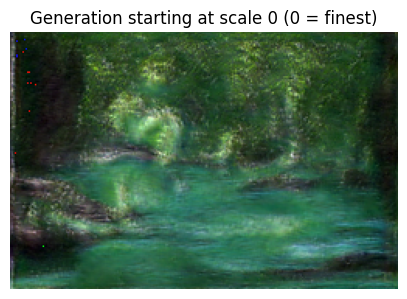

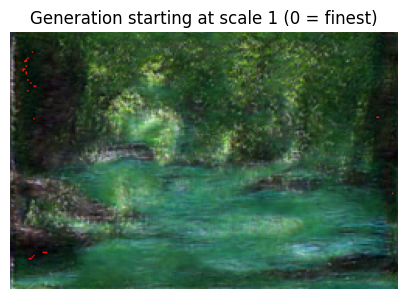

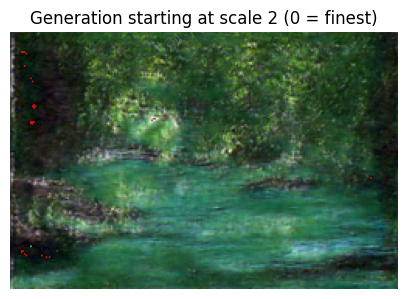

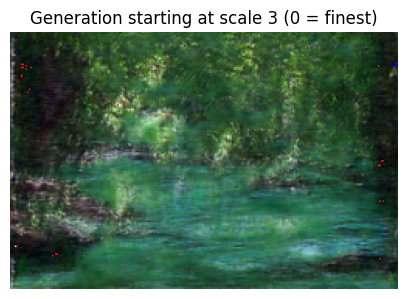

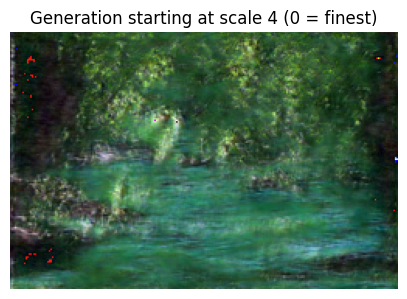

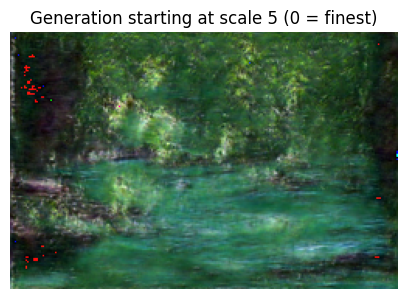

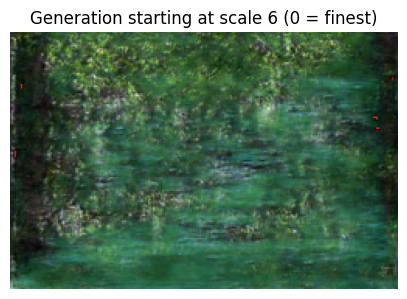

In [241]:
for start_scale in range(N):
    final_gen = generate_multiscale(Genarators, N, scales, sigma_n, z_star, device=device, start_scale=start_scale)
    final_img = final_gen[-1].cpu().squeeze()

    plt.figure(figsize=(5,5))
    plt.title(f"Generation starting at scale {start_scale} (0 = finest)")
    plt.imshow(to_pil_image(final_img))
    plt.axis('off')
    plt.show()

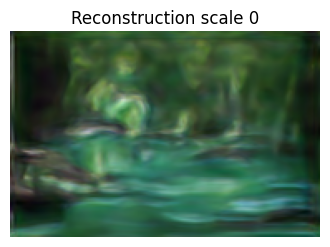

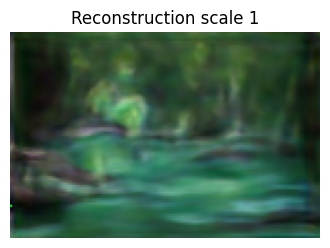

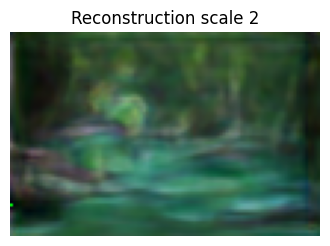

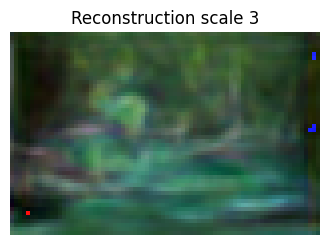

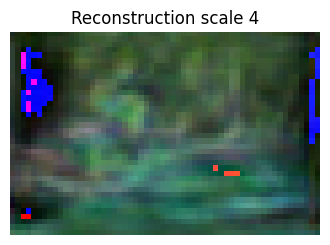

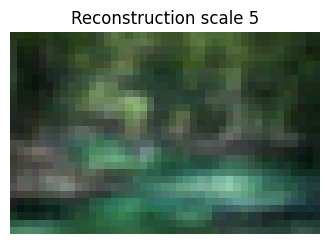

In [240]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec, scales):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(to_pil_image(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:],scales)

In [252]:
torch.random.manual_seed(1)
for x in range(N):  
    print(torch.rand(1),torch.rand(1))

tensor([0.7576]) tensor([0.2793])
tensor([0.4031]) tensor([0.7347])
tensor([0.0293]) tensor([0.7999])
tensor([0.3971]) tensor([0.7544])
tensor([0.5695]) tensor([0.4388])
tensor([0.6387]) tensor([0.5247])
tensor([0.6826]) tensor([0.3051])
